## Pendulum: One-step Method

In [1]:
import sys
#sys.path.append('/Users/josorior/Documents/UW/research/keql/KEQL/source')
#sys.path.append('/Users/yasaminjalalian/Repos/KEQL/source')
sys.path.append('/home/juanfelipe/Desktop/research/keql/source')

In [2]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import *
from models import * 
from kernels import *
from data_loader import *
from loss import *
from utils import *

import jax.numpy as jnp
from jax import grad, jit
from jax.scipy.optimize import minimize
from jax.config import config; 
config.update("jax_enable_x64", True)

from functools import partial # for jit to make codes faster

In [4]:
model = 'pendulum'

### Cost function

Create `Kphiphi` to find the regularizer `R`

In [5]:
# Create Kphiphi
X = x_train_all.flatten()
sigma_K = jnp.mean(jnp.array([0.14840741, 0.88888889, 0.88888889]))
Kphiphi = Kphiphi_assembly( X[:e] , k = 'Gaussian', k_param = 0.5)

In [6]:
# Tr(Kphiphi)
trK = jnp.trace(Kphiphi[0:e,0:e])
# Tr(D^1D^1 Kphiphi)
trDDK = jnp.trace(Kphiphi[e:2*e,e:2*e])
# Tr(D^2D^2 Kphiphi)
trD2D2K = jnp.trace(Kphiphi[2*e:3*e,2*e:3*e])
# First block
ones = jnp.ones((e))
# Second block
second = ones*trDDK/trK
# Third block
third = ones*trD2D2K/trK
# Assemble R or take the diagonal or Kphiphi
diagonal = jnp.concatenate((ones,second,third))
R = jnp.diag(diagonal)

Create objective function `L`

In [8]:
def L(Z, X, U, f, R, lmbd):
    """Cost function for one step method.
    
    Args:
        Z: Vector of optimization variables in the cost function. 2*m*N
        X: List of mN points of dimension d.
        U: List of mN values of functions u^(1),...u^(N).
        f: List of mN values of functions u^(1),...u^(N).
        R: Matrix that regularizes Kphiphi
    Returns:
        scalar: a cost of this solution.    
    """ 
   
    ### First term

    # Build S_N
    S1 = jnp.vstack([X,U]).T
    S = jnp.hstack([S1,Z])

    # Scaling S_N
    scaler_s_train = MinMaxScaler()
    S = scaler_s_train.fit_transform(S)
    
    # Gamma(S_N,S_N)
    sigma_Gamma = 1.35 # From 2-step
    Gamma = K(Gaussian, S, S, sigma_Gamma)
    alpha_Gamma = 1e-13 # nugget from 2-step !!!
    Gamma = Gamma + alpha_Gamma*jnp.eye(jnp.size(Gamma,0)) 
    #print("cond(Gamma) = ", jnp.linalg.cond(Gamma))

    # (Gamma(S_N,S_N) + alpha_Gamma*I)^-1 * f
    b = jnp.linalg.solve(Gamma,f)

    # First term
    rkhs_P = 5723629396.1
    L1 = jnp.dot(f.T , b) / rkhs_P
    #print("L1(Z_warm) = ", L1)


    ### Second term

    L2 = 0.

    sigma_K = jnp.mean(jnp.array([0.24994344, 0.74908123, 0.74908123])) # From 2-step
    Kphiphi = Kphiphi_assembly( X[:e] , k = 'Gaussian',k_param = sigma_K)
    alpha_K = 1e-6
    Kphiphi = Kphiphi + alpha_K*R 
    #print("cond(Kphiphi) = ", jnp.linalg.cond(Kphiphi))

    rkhss = [1.1833129190245972, 10.115269194432372, 136.2124679543351]
    ZZ = jnp.hstack((U.reshape(-1,1),Z))
    for i in range(3):
        Z_i = jnp.reshape(ZZ[e*i:(i+1)*e,:].T,(e*3,1))
        c = jnp.linalg.solve(Kphiphi,Z_i)
        L2 += jnp.reshape(jnp.dot(Z_i.T , c),())/rkhss[i]

    #print("L2(Z_warm) = ",L2)

    return L1 + lmbd*L2 # Return loss.

#### Gradient descent

Training data

In [9]:
# First column in Gamma(S_N,S_N)
X = x_train_all.flatten() # N*m * 1

# Second column in Gamma(S_N,S_N)
U = u_train.T.reshape(e*m,) # N*m * 1

# f(X_N)
f = f_Train(model)

Initial guess: `Z_warm`

In [10]:
# Load gradients from 2-step
u_x_pred_train  = np.load('data/u_x_pred_train.npy')
u_xx_pred_train = np.load('data/u_xx_pred_train.npy')
# Build Z_warm
Z_warm = np.hstack([u_x_pred_train.T.reshape(e*m,1),u_xx_pred_train.T.reshape(e*m,1)])

In [11]:
L(Z_warm, X, U, f, R, lmbd = 1)

Array(3143002.53562863, dtype=float64)

Which `lmbd` in the expression `L1 + lmbd*L2` should I use if `L1` >> `L2` ?

In [12]:
lmbd_min = 1/3 # It always picks the smallest here 

Initialize the grad functions with `jit` to be efficient

In [22]:
grad_Z = jit(grad(L, argnums=0))

# Run once to trigger JIT compilation.
grad_Z(Z_warm, X, U, f,R,lmbd= lmbd_min)
# Warm start here !!!

Array([[ 4.05700993e+03,  5.03663538e+02],
       [ 3.13655784e+04,  3.91859310e+03],
       [-3.79831358e+04,  1.12395820e+03],
       [-4.23621783e+03,  1.27378015e+00],
       [-8.53177533e+03,  2.43380543e+02],
       [-3.28154724e+03,  7.73264874e+02],
       [-3.25153032e+04, -1.91103075e+03],
       [-1.15686738e+05,  8.08451062e+02],
       [-2.07877521e+04, -1.18351842e+03]], dtype=float64)

Run the gradient descent for `100` epochs

In [ ]:
# Sanity check here!
plt.plot(x_train[0:e], U[0:e])
plt.plot(x_train[0:e], u_x_pred_train[0:e,0])
plt.plot(x_train[0:e], u_x_train[:,0])
plt.show()

### Gradient descent

In [15]:
# Only do this for the first time - 
Z = np.copy(Z_warm)
#Z = np.load('data/Z.npy')

In [31]:
# If trained previously use Z
if np.all(Z != Z_warm):
    Z = np.load('data/Z.npy')
else:
    Z = np.copy(Z_warm)
learning_rate = 1e-3
for i in range(1000):
    delta_Z = grad_Z(Z, X, U, f,R,lmbd=lmbd_min)
    lr = jnp.linalg.norm(Z)/jnp.linalg.norm(delta_Z)*learning_rate
    Z -= lr * delta_Z
    if i % 10 == 0:
        print(L(Z, X, U, f, R, lmbd=lmbd_min))
    
# Save at the end of iterations
np.save('data/Z.npy',Z)

23368.96285327096
23362.591609567622
23356.24643606067
23349.927039541843
23343.633131043956
23337.364425775493
23331.12064305546
23324.901506249713
23318.706742708473
23312.536083704217
23306.389264371013
23300.26602364488
23294.16610420445
23288.08925241365
23282.03521826406
23276.003755319307
23269.994620659498
23264.00757482698
23258.042381772768
23252.098808804152
23246.176626532462
23240.275608822347
23234.39553274156
23228.536178511502
23222.6973294586
23216.878771966454
23211.08029542873
23205.30169220299
23199.542757564763
23193.803289662854
23188.083089475076
23182.38196076495
23176.699710038458
23171.03614650235
23165.391082022696
23159.764331083486
23154.15571074729
23148.565040615053
23142.99214278749
23137.43684182682
23131.898964718916
23126.37834083638
23120.874801901737
23115.388181951963
23109.91831730256
23104.46504651329
23099.02821035341
23093.607651768187
23088.203215845726
23082.81474978444
23077.44210286032
23072.085126395814
23066.743673728575
23061.41760018064

## Evaluation of `Z`

In [24]:
# Load true gradients from 2-step
u_x_train = np.load('data/u_x_train.npy')
u_xx_train = np.load('data/u_xx_train.npy')
# Build true Z
Z_true = np.hstack([u_x_train.T.reshape(e*m,1),u_xx_train.T.reshape(e*m,1)])

> One-step Method vs Truth

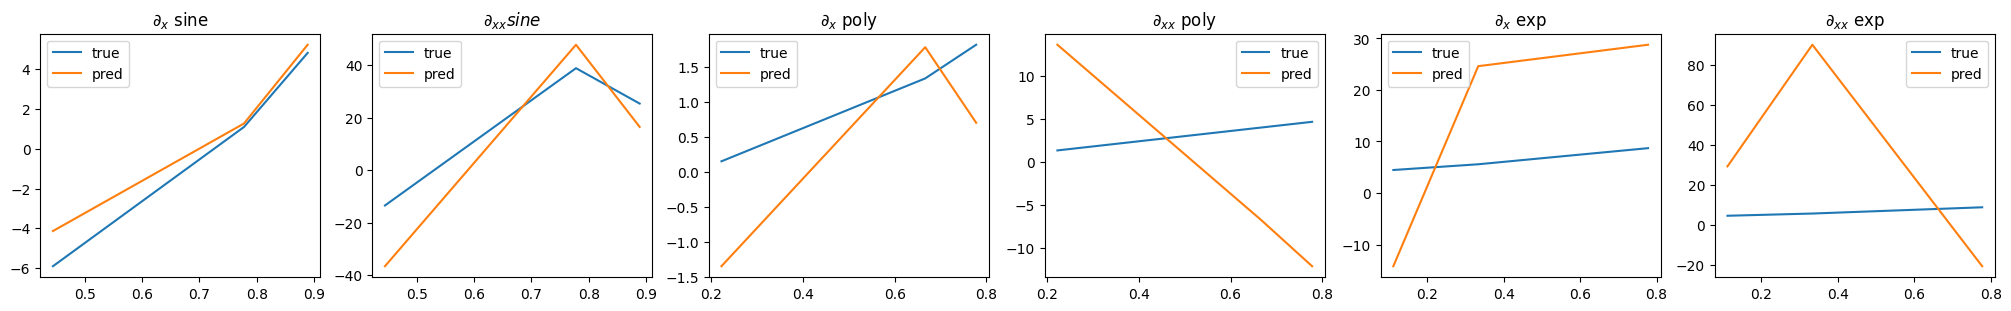

In [32]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 1, ncols=6, figsize = (20,3),constrained_layout=True)
ax1.set_title(r'$\partial_x$ sine')
ax1.plot(x_train[0:e],Z_true[0:e,0],label ='true')
ax1.plot(x_train[0:e],Z[0:e,0],label ='pred')
ax1.legend()
ax2.set_title(r'$\partial_{xx} sine$')
ax2.plot(x_train[0:e],Z_true[0:e,1],label ='true')
ax2.plot(x_train[0:e],Z[0:e,1],label ='pred')
ax2.legend()
ax3.set_title(r'$\partial_x$ poly')
ax3.plot(x_train[e:2*e],Z_true[e:2*e,0],label ='true')
ax3.plot(x_train[e:2*e],Z[e:2*e,0],label ='pred')
ax3.legend()
ax4.set_title(r'$\partial_{xx}$ poly')
ax4.plot(x_train[e:2*e],Z_true[e:2*e,1],label ='true')
ax4.plot(x_train[e:2*e],Z[e:2*e,1],label ='pred')
ax4.legend()
ax5.set_title(r'$\partial_x$ exp')
ax5.plot(x_train[2*e:3*e],Z_true[2*e:3*e,0],label ='true')
ax5.plot(x_train[2*e:3*e],Z[2*e:3*e,0],label ='pred')
ax5.legend()
ax6.set_title(r'$\partial_{xx}$ exp')
ax6.plot(x_train[2*e:3*e],Z_true[2*e:3*e,1],label ='true')
ax6.plot(x_train[2*e:3*e],Z[2*e:3*e,1],label ='pred')
ax6.legend()
plt.show()

> Two-step Method vs Truth

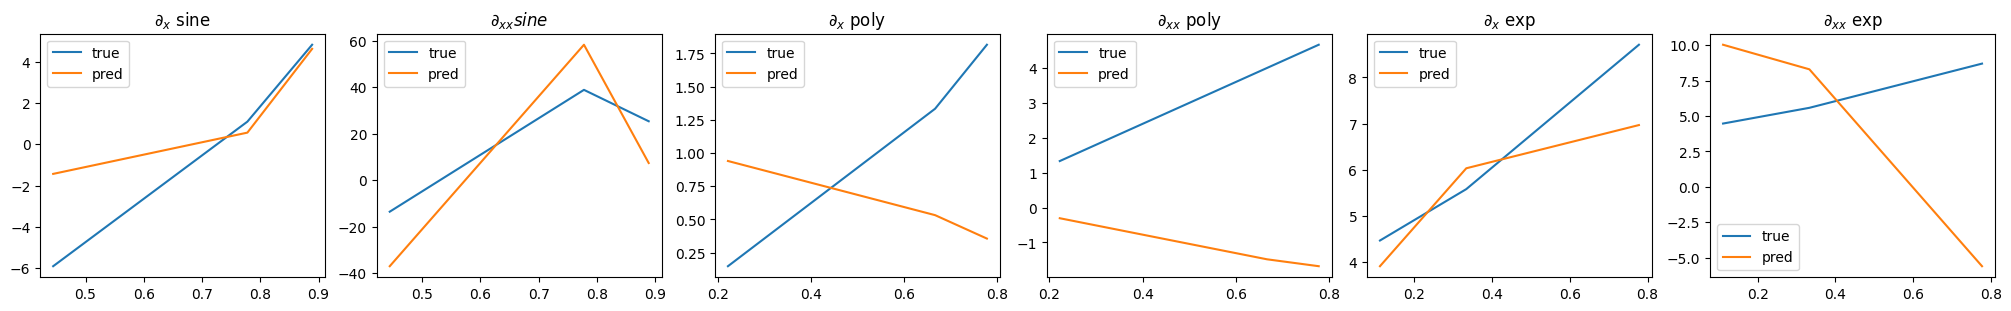

In [26]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 1, ncols=6, figsize = (20,3),constrained_layout=True)
ax1.set_title(r'$\partial_x$ sine')
ax1.plot(x_train[0:e],Z_true[0:e,0],label ='true')
ax1.plot(x_train[0:e],Z_warm[0:e,0],label ='pred')
ax1.legend()
ax2.set_title(r'$\partial_{xx} sine$')
ax2.plot(x_train[0:e],Z_true[0:e,1],label ='true')
ax2.plot(x_train[0:e],Z_warm[0:e,1],label ='pred')
ax2.legend()
ax3.set_title(r'$\partial_x$ poly')
ax3.plot(x_train[e:2*e],Z_true[e:2*e,0],label ='true')
ax3.plot(x_train[e:2*e],Z_warm[e:2*e,0],label ='pred')
ax3.legend()
ax4.set_title(r'$\partial_{xx}$ poly')
ax4.plot(x_train[e:2*e],Z_true[e:2*e,1],label ='true')
ax4.plot(x_train[e:2*e],Z_warm[e:2*e,1],label ='pred')
ax4.legend()
ax5.set_title(r'$\partial_x$ exp')
ax5.plot(x_train[2*e:3*e],Z_true[2*e:3*e,0],label ='true')
ax5.plot(x_train[2*e:3*e],Z_warm[2*e:3*e,0],label ='pred')
ax5.legend()
ax6.set_title(r'$\partial_{xx}$ exp')
ax6.plot(x_train[2*e:3*e],Z_true[2*e:3*e,1],label ='true')
ax6.plot(x_train[2*e:3*e],Z_warm[2*e:3*e,1],label ='pred')
ax6.legend()
plt.show()